In [23]:
import json
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.special as SciSpecial
from sklearn.linear_model import Lars
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real
import math
import datetime
import os
#from scipy.optimize import differential_evolution
from scipy.stats import wasserstein_distance

class StochasticPCE:
    # Intialization
    def __init__(self, config, X = None, numDOE = None):

        self.realization = False
        self.initialized = False

        # Read the JSON config file
        with open(config, 'r') as json_file:
            loaded_config_data = json.load(json_file)

        try:
            # Inmport the variables 
            self.X_type = loaded_config_data["X_type"]
            self.Z_type = loaded_config_data["Z_type"]
            self.p_max = loaded_config_data["max_poly_degree"]
            self.q_list = loaded_config_data["q_norm"]
            self.solver = loaded_config_data["Solver"]
            self.result_path = loaded_config_data["save_result_path"]

            self.num_Vars = len(self.X_type)
            self.p_list = np.arange(1, self.p_max+1)

            if "X_path" not in loaded_config_data:
                if X is not None:
                    self.X = X
                    self.check_shape(self.X, (np.shape(self.X)[0], len(self.X_type)))
                else:
                    raise ValueError("No input variables X")
            else:
                self.X_path = loaded_config_data["X_path"]
                data = sio.loadmat(self.X_path)
                self.X = np.array([data["X"]])[0]
            
            if numDOE is not None:
                if not ( 0 < int(numDOE) < np.shape(self.X)[0]):
                    raise ValueError(f"Input numDOE: {numDOE}, it has to be in the range of (0 , {np.shape(self.X)[0]}].")
                else:
                    self.X = self.X[:numDOE,:]

            # Initialize 
            self.N = np.shape(self.X)[0]  # number of realization 
            self.Y = np.array([])
            self.X_train = self.X  #only use to store the training X datasets, wont be overwritten
            self.A_trunc = np.array([])
            self.InfoMat = np.array([])
            self.coeffs = np.array([])
            self.SparseOrderTable = np.array([])
            self.active_list = np.array([])
            self.SparseInfoMat = np.array([])
            self.error_esti = 100000
            self.error_corr = 100000
            self.error_corr_record = np.array([])
            self.first_order_Sobol_indices = {}
            self.Sigma = 0
            self.NfoldMLE_CVs = 0
            self.best_p = 0 
            self.best_q = 0
            
            # Checking initialized properly or not 
            self.check_length(np.shape(self.X)[1],self.num_Vars)
            self.check_in_range_type1(max(self.q_list),0 , 1)
            self.check_in_range_type1(min(self.q_list),0 , 1)
            self.check_type(self.solver, {"HybridLAR","LAR","OLS"})

            for type_ in self.X_type:
                self.check_type(self.X_type[type_],{"Uniform", "Gaussian", "Gamma","Beta"})
                if self.X_type[type_] == "Gamma":
                    if "OrthPolyParams" in loaded_config_data:
                        self.OrthoPoly_params = loaded_config_data["OrthPolyParams"]
                    else:
                        raise ValueError(f"There is paramter with {self.X_type[type_]} type in Input variables,please setting its required params in config.")

            if self.Z_type != []:
                for type_ in self.Z_type: 
                    self.check_type(type_, {"Uniform", "Gaussian", "Gamma","Beta"})
                self.stocahstic_solver = True
                self.A_trunc_all = np.array([])
            else:
                self.stocahstic_solver = False
            
            # If pass the all the checking, then Initialized successfully
            self.initialized = True
            self.converge = False
            self.overfit = False

            # Display the current setting 
            self.display_line()        
            print("Initialized SPCE successfully")
            if self.stocahstic_solver:
                print("     Using Stochastic PCE solver")
            else:
                print("     Using conventional LAR-PCE solver")
            print("     Input X with shape (N,num_Vars):", np.shape(self.X))
            print("     Input Y with shape (N,1)       :", np.shape(self.Y))
            print("     WARNING, No realization will be inputed when initialize the clase ")
            print("           Please use method: InputRealization() to initialize realization Y")
            print(" ")
            print("     Config information: ")
            print("  ",json.dumps(loaded_config_data, indent=4))
            
        except ValueError as e:
            print(f"    Error from Initialization(): {e}")

    def InputRealization(self, Y):
        self.display_line() 
        print("Input Realization")
        self.check_initialized()
        try:
            self.check_shape(Y, (self.N, 1))
            self.Y = Y
            self.realization = True
            print("Input Realization successfully")
            print("     Input X with shape (N,num_Vars):", np.shape(self.X))
            print("     Input Y with shape (N,1)       :", np.shape(self.Y))

        except ValueError as e:
            print(f"    Error from InputRealization(): {e}")


    # Preprossesor 
    def CreateOrderTable(self, poly_degree, q,  plot_ = False):
        self.display_line() 
        print("Create Order-Table")
        try:
            self.check_initialized()
            self.check_in_range_type1(q, 0 , 1)
            self.check_in_range_type3(poly_degree, 1 , self.p_max)

            M = self.num_Vars
            # Define the degrees for each variable: p_array
            p_array = np.arange(poly_degree+1)  # Considering degrees 0, 1, 2, and 3
            # Generate all possible combinations: A
            A = np.array(np.meshgrid(*[p_array]*M)).T.reshape(-1, M)
            A_q = A**q
            A_trunc = A[A_q.sum(axis=1)**(1/q) <= poly_degree]
            self.A_trunc = np.copy(A_trunc)

            print("Create Order-Table successfully")
            print(f"    Info: M:{M}, p:{poly_degree}, q:{q}, Shape of Order-Table (cardA, numVars): {np.shape(self.A_trunc)}")

            if self.stocahstic_solver:
                M = M +1 #For unknown var Z
                # Generate all possible combinations: A
                A = np.array(np.meshgrid(*[p_array]*M)).T.reshape(-1, M)
                A_q = A**q
                A_trunc = A[A_q.sum(axis=1)**(1/q) <= poly_degree]
                self.A_trunc_all = np.copy(A_trunc)
                print("Create Order-Table with Z-latent Var successfully ")
                print(f"    Info: M:{M}, p:{poly_degree}, q:{q}, Shape of Order-Table (cardA, numVars): {np.shape(self.A_trunc_all)}")

            if plot_:
                # Create a 3D plot
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(A_trunc[:,0], A_trunc[:,1], A_trunc[:,2], cmap='viridis', edgecolor='k')
                ax.set_xlabel('X-axis')
                ax.set_ylabel('Y-axis')
                ax.set_zlabel('Z-axis')
                ax.set_title('Visualization of First 3 3rd-Order Polynomials')
                plt.show()

            if self.stocahstic_solver:
                return self.A_trunc , self.A_trunc_all
            else:
                return self.A_trunc
        
        except ValueError as e:
            print(f"    Error from CreateOrderTable(): {e}")

    def CreateInfoMatrix(self,check_orthonorm = False, show_info_ = False):
        self.display_line() 
        print("Create Information Matrix")

        try:
            #Initialize the information matrix
            self.check_empty_array(self.A_trunc)
            InfoMat = np.ones((self.N, np.shape(self.A_trunc)[0]))

            for dist_type in enumerate(self.X_type.values()):

                i_X = dist_type[0]
                poly_degree = self.A_trunc[:,i_X]
                poly_degree = poly_degree.reshape(-1, 1)
                
                if dist_type[1] == "Uniform":
                    InfoMat_i_X = self.Hilbertian_basis_Legendre(poly_degree,self.X[:,i_X],show_info_)
                elif dist_type[1] == "Gaussian":
                    InfoMat_i_X = self.Hilbertian_basis_Hermite(poly_degree,self.X[:,i_X],show_info_)
                elif dist_type[1] == "Gamma":
                    var_i = list(self.X_type.keys())[i_X]
                    if var_i not in self.OrthoPoly_params:
                        raise ValueError(f"No OrthoPoly_params for {var_i}, please check config file again.")
                    else:
                        alpha = self.OrthoPoly_params[var_i]
                    InfoMat_i_X = self.Hilbertian_basis_genlaguerre(poly_degree,alpha,self.X[:,i_X],show_info_)
                else:
                    raise ValueError("Beta distribution is not avaiable now.")
                InfoMat = InfoMat*InfoMat_i_X
            
    
            self.check_shape(InfoMat,(self.N, np.shape(self.A_trunc)[0]))
            self.InfoMat = InfoMat   
            
            print(f"Create Information Matrix successfully, shape: {np.shape(self.InfoMat)}")
            if check_orthonorm:
                orthonorm_property = np.mean(InfoMat*InfoMat,axis=0)
                print(f"    Checking OrthoNormalization: Min: {np.min(orthonorm_property)}, Max: {np.max(orthonorm_property)}, Ideal is 1.0.")

            return self.InfoMat

        except ValueError as e:
            print(f"    Error from CreateInfoMatrix(): {e}")


    # PCE Solver 
    def Solver(self, solver_ = None, show_info_ = False):
        self.display_line() 
        print("Start Solving")
        try:
            self.check_realization()
            self.check_empty_array(self.InfoMat)
            self.check_empty_array(self.A_trunc)
            error_esti = self.error_esti
            error_corr = self.error_corr
            coeffs_candi = np.array([])
            active_list_candi = np.array([])
            SparseOrderTable_candi = np.array([])
            
            if solver_ is None:
                raise ValueError("varialbe: solver_ cannot be None, please specify the solver ")
            else:
                self.check_type(self.solver, {"HybridLAR","LAR","OLS"})
            print(f"    Using {solver_} Solver")
            
        
            if solver_ == "HybridLAR":
                self.active_list, _ = self.LAR_solver()
                n_active_list = self.active_list
                if len(n_active_list) > self.N:
                    n_active_list = n_active_list[:self.N-1]
                    
                # Loop over all the metamodel
                for i_active_list in range(1, len(n_active_list) + 1): 
                    self.active_list = n_active_list[:i_active_list]
                    self.SparseOrderTable = self.A_trunc[self.active_list,:]
                    self.SparseInfoMat = self.InfoMat[:,self.active_list]
                    self.coeffs = self.LeastSquare_solver(self.SparseInfoMat)
                    error, error_str = self.LOOCV(show_info_)

                    if error <= error_esti:
                        error_esti = error
                        error_corr = error_str
                        coeffs_candi = np.copy(self.coeffs)
                        #active_list_candi = np.copy(self.active_list)
                        SparseOrderTable_candi = np.copy(self.SparseOrderTable)
      
            elif solver_ == "LAR":
                self.active_list, coeffs = self.LAR_solver()   
                n_active_list = self.active_list
                n_coeffs = coeffs[np.abs(coeffs)>0]
                if len(n_active_list) > self.N:
                    n_active_list = n_active_list[:self.N-1]
                    n_coeffs = n_coeffs[:self.N-1]

                # Loop over all the metamodel
                for i_active_list in range(2, len(n_active_list) + 1): 
                    active_list = n_active_list[:i_active_list]
                    SparseOrderTable = self.A_trunc[active_list,:]
                    sparseInfoMat = self.InfoMat[:,active_list]
                    self.active_list, coeffs = self.LAR_solver(sparseInfoMat) 
                    self.SparseOrderTable = SparseOrderTable[self.active_list,:]
                    self.SparseInfoMat = sparseInfoMat[:,self.active_list]
                    self.coeffs = coeffs[np.abs(coeffs)>0]
                    self.coeffs = self.coeffs.reshape(-1,1)
                    error, error_str = self.LOOCV(show_info_)

                    if error <= error_esti:
                        error_esti = error
                        error_corr = error_str
                        coeffs_candi = np.copy(self.coeffs)
                        #active_list_candi = np.copy(self.active_list)
                        SparseOrderTable_candi = np.copy(self.SparseOrderTable)

            else:
                self.coeffs = self.LeastSquare_solver()
                self.active_list = np.arange(len(self.coeffs))
                self.SparseOrderTable = self.A_trunc
                self.SparseInfoMat = self.InfoMat[:,self.active_list]
                error, error_str = self.LOOCV(show_info_)

                if error < error_esti:
                    error_esti = error
                    error_corr = error_str
                    coeffs_candi = np.copy(self.coeffs)
                    #active_list_candi = np.copy(self.active_list)
                    SparseOrderTable_candi = np.copy(self.SparseOrderTable)
                    
            # Replaced by the best candidate
            coeffs = coeffs_candi
            error_corr = error_corr
            error_loo = error_esti
            #active_list = active_list_candi
            SparseOrderTable = SparseOrderTable_candi
            
            print("Solve for coefficients successfully")

            return SparseOrderTable, coeffs, error_corr, error_loo
        except ValueError as e:
            print(f"Error from Solver(): {e}")

    def LOOCV(self,show_info_ = False):
        if show_info_:
            self.display_line() 
            print("Run LOOCV process")

        try:
            self.check_empty_array(self.InfoMat)
            self.check_empty_array(self.SparseOrderTable)
            self.check_empty_array(self.coeffs)
            self.check_empty_array(self.active_list)

            #Formulate the sparse Information Matrix for original one
            #self.SparseInfoMat = self.InfoMat[:,self.active_list]  -> remove, compute it in solver()
            self.check_shape(self.SparseInfoMat, (self.N, len(self.coeffs)))
            self.check_shape(self.coeffs, (len(self.active_list), 1))

            PHI = self.SparseInfoMat@ np.linalg.inv(self.SparseInfoMat.T @ self.SparseInfoMat) @ self.SparseInfoMat.T
            H = np.diagonal(PHI)

            Y_hat = self.SparseInfoMat @ self.coeffs
            self.check_shape(Y_hat, np.shape(self.Y))

            
            Err_loo = np.mean(((self.Y - Y_hat) / (1-H))**2)
            err_loo = Err_loo / np.var(self.Y)

            # Corrected error estimates
            C_emp_inv = np.linalg.inv((self.SparseInfoMat.T @ self.SparseInfoMat)/self.N)
            C_emp_tr = np.trace(C_emp_inv) / self.N
            Correct_fac = ((1+C_emp_tr) / (self.N - len(self.active_list)))
            err_loo_str = Correct_fac*err_loo

            # determination coefficient
            Q_2 = 1-err_loo
            Q_2_correct = 1-err_loo_str

            
            if show_info_:
                print("LOOCV successfully")
                print(f"    Leave-one-out error         : {Err_loo}")
                print(f"    Relative leave-one-out error: {err_loo}, Q2: {Q_2}")
                print(f"    Relative corrected error    : {err_loo_str}, Q2_corr: {Q_2_correct}")

            return Err_loo, err_loo_str
            
        except ValueError as e:
            print(f"Error from LOOCV(): {e}")    

    def BuildModel_PCE(self, tol_err = 10E-7, **kwargs):
        self.display_section()
        print("Start Building PCE Surrogate Model")
        opt_show_info = False
        opt_check_orthonorm = False
        opt_save_result_ = False
        opt_overfit_count = 2

        count = 0
        error_last = 100000
        error_corr = 1000000
        err_loo_min = 100000
        error_increase_count = 0
        record_min_error = 100000
        record_SparseOrderTable = np.array([])
        record_coeffs = np.array([])
        record_active_list = np.array([])

        try:
            if 'show_info_' in kwargs:
                opt_show_info = kwargs['show_info_']
            
            if 'check_orthonorm_' in kwargs:
                opt_check_orthonorm = kwargs['check_orthonorm_']

            if 'save_result_' in kwargs:
                opt_save_result_= kwargs['save_result_']
            
            if 'result_path_' in kwargs:
                result_path = kwargs['result_path_']

            if 'overfit_count_' in kwargs:
                opt_overfit_count = kwargs['overfit_count_']

            else:
                result_path = self.result_path

            self.check_initialized()
            self.check_realization()

            for index_i, p in enumerate(self.p_list):
                for index_j, q in enumerate(self.q_list):
                    self.display_section()
                    print(f"Building Model, iter: {count}, poly_degree: {p}, truncate_q: {q}")
                    
                    if error_last < error_corr:
                        error_increase_count = error_increase_count+1
                    else:
                        error_increase_count = 0
                        
                    if error_increase_count >= opt_overfit_count:
                        self.overfit = True
                        break

                    error_last = error_corr
                    count = count +1

                    self.CreateOrderTable(p,q)
                    self.CreateInfoMatrix(check_orthonorm = opt_check_orthonorm, show_info_= opt_show_info)
                    SparseOrderTable, Coeffs, error_corr, err_loo=  self.Solver(solver_= self.solver, show_info_= opt_show_info)
                    self.error_corr_record = np.append(self.error_corr_record, error_corr)
                    print(SparseOrderTable)

                    if error_corr < record_min_error:
                        A_trunc = self.A_trunc
                        record_p = p
                        record_q = q
                        record_min_error = error_corr
                        record_SparseOrderTable = SparseOrderTable
                        record_coeffs = Coeffs
                        err_loo_min = err_loo

                        if error_corr <= tol_err:
                            self.converge = True
                            break
                   
                if self.converge or self.overfit:
                    break
            
            # Overwrite by the best record
            
            record_active_list = []

            self.CreateOrderTable(self.p_list[-1],int(self.q_list[-1]))
            # Iterate through each row of rows_to_find
            for row_to_find in record_SparseOrderTable:
                # Check if the row matches any row in data
                for i, row in enumerate(self.A_trunc):
                    if np.array_equal(row, row_to_find):
                        # If a match is found, add the index to the sequence_indices list
                        record_active_list.append(i)
                        break  # Move to the next row_to_find
                    
            self.error_corr = record_min_error
            self.SparseOrderTable = record_SparseOrderTable 
            self.coeffs = record_coeffs 
            self.active_list = record_active_list 

            self.best_p = record_p
            self.best_q = record_q
            self.err_loo_min = err_loo_min
            self.display_section()
            self.display_section()
            if self.converge:
                print(f"Building Surrogate Model successfully, total run: {count}")
                print(f"    Stop Criteria: Corrected Error <= {tol_err}")
                print(f"    Result: poly_degree: {record_p}, truncate_q: {record_q}")
                print(f"            Corrected Error: {error_corr}")
            
            elif self.overfit:
                print("Building Surrogate Model, Not Converge")
                print(f"    Stop Criteria: Overfitting")
                print(f"    Result: poly_degree: {record_p}, truncate_q: {record_q}")
                print(f"            Corrected Error: {self.error_corr}")

            else:
                print("Building Surrogate Model, Not Converge")
                print(f"    Stop Criteria: Running all the possible combination. total run: {count}")
                print(f"    Result: poly_degree: {record_p}, truncate_q: {record_q}")
                print(f"            Corrected Error: {self.error_corr}")
        
            if opt_save_result_:
                self.Save_result(result_path)

            self.CreateInfoMatrix()
            print(np.shape(self.coeffs))
            print(np.shape(self.InfoMat[:,self.active_list]))
            print(self.SparseOrderTable)
            print(self.A_trunc)
            print(self.active_list)
            
            X_train = self.X
            Y_train = self.InfoMat[:,self.active_list]@ self.coeffs
            self.display_section()

            return X_train, Y_train
            
        except ValueError as e:
            print(f"    Error from BuildModel_PCE(): {e}")
        
    def BuildModel_SPCE(self, tol_err = 10E-7, **kwargs):
        self.display_section()
        print("Start Building SPCE Surrogate Model")
        opt_show_info = False
        opt_check_orthonorm = False
        opt_overfit_count = 10
        opt_Ns = 8
        opt_NumGP = 30
        opt_numKFold = 4
        
        try:
            if 'show_info_' in kwargs:
                opt_show_info = kwargs['show_info_']
            
            if 'check_orthonorm_' in kwargs:
                opt_check_orthonorm = kwargs['check_orthonorm_']

            if 'save_result_' in kwargs:
                opt_save_result_= kwargs['save_result_']
            
            if 'result_path_' in kwargs:
                result_path = kwargs['result_path_']

            if 'overfit_count_' in kwargs:
                opt_overfit_count = kwargs['overfit_count_']
            else:
                result_path = self.result_path

            if 'num_iter_warmstart_' in kwargs:
                opt_Ns = kwargs['num_iter_warmstart_']
            
            if 'num_iter_GP_' in kwargs:
                opt_NumGP = kwargs['num_iter_GP_']
            
            if 'num_k_fold_' in kwargs:
                opt_numKFold = kwargs['num_k_fold_']

            self.check_initialized()
            self.check_realization()
            self.BuildModel_PCE(tol_err= tol_err, show_info_ = opt_show_info, overfit_count_ = opt_overfit_count , check_orthonorm_ = opt_check_orthonorm)
            
            print(self.SparseOrderTable)
            # Dont need to + 1 is because its index is (len(self.X_type)-1) + 1
            OrderTable_Z = self.A_trunc_all[self.A_trunc_all[:, len(self.X_type)] != 0]
            SparseOrderTable = self.A_trunc_all[self.active_list,:]
            print(SparseOrderTable)
            SparseOrderTable_Z = np.concatenate((SparseOrderTable, OrderTable_Z), axis=0)
            print(SparseOrderTable_Z)
            self.A_trunc = SparseOrderTable_Z

            Z_type = self.Z_type[0]

            self.CreateInfoMatrix()

            # Initialized the coeffs
            #coeffs_Z_init = min(self.coeffs) + (max(self.coeffs) - min(self.coeffs)) * np.random.rand(np.shape(OrderTable_Z)[0],1)
            coeffs_Z_init =  np.random.rand(np.shape(OrderTable_Z)[0],1)
            coeffs_init = np.concatenate((self.coeffs,coeffs_Z_init), axis=0)
            coeffs_init = np.transpose(coeffs_init)
            coeffs_init = coeffs_init.astype(np.float64)
            
            # Dont need to + 1 is because its index is (len(self.X_type)-1) + 1
            poly_degree_Z = self.A_trunc[:,len(self.X_type)]
            poly_degree_Z = poly_degree_Z.reshape(-1, 1)

            # Specify the number of Integration points: p <= 2n − 1
            # Here we want to intrgral M(x)**2, therefore: 2*max_P <= 2n -1
            # 0.5*(2*max_P+1) <= int(n), after sorting up: n = max_P +1 
            num_samp = int(max(poly_degree_Z)+1)

            kf = KFold(n_splits=opt_numKFold, shuffle=True)
            X = np.copy(self.X)
            Y = np.copy(self.Y)
            
            print(f"Error-Loo is {round(np.sqrt(self.err_loo_min),6)}")
            print(f"Sigma searching range: ({round(0.1*np.sqrt(self.err_loo_min),6)}, {round(1.1*np.sqrt(self.err_loo_min),6)})")

            # Define the objective function with N-fold cross-validation
            def BO_hyperparams_objfun(hyper_sigma):
                # Initialize the KFold splitter
                if hyper_sigma >= 0.75*np.sqrt(self.err_loo_min):
                    opt_Ns_ = int(0.25*opt_Ns)
                elif hyper_sigma >= 0.5*np.sqrt(self.err_loo_min):
                    opt_Ns_ = int(0.5*opt_Ns)
                else:
                    opt_Ns_ = opt_Ns
                 # In the literature, the Warm-Start is from sqrt(erorr_loo)
                # Warm-Start list, where Sigma is the target sigma
                self.coeffs_update = coeffs_init.tolist()[0]
                WarmStart = np.linspace(np.log(np.sqrt(self.err_loo_min)), np.log(hyper_sigma), num= opt_Ns_)
                #WarmStart = np.linspace(np.log(hyper_sigma), np.log(hyper_sigma), num= opt_Ns)
                WarmStart_sigma = np.exp(WarmStart)

                MLE_CV = 0
                
                # Split the data into N folds
                for train_index, test_index in kf.split(X): 
                    # Training 
                    self.cv_index = train_index
                    self.X = X[self.cv_index,:]
                    self.Y = Y[self.cv_index,:]
                    self.N = len(self.Y)

                    for sigma_i in WarmStart_sigma:
                        # Define the objective function
                        # Here input x is the coeffs that we want to optimize.

                        def MLE_objfun(x):
                            #print(np.min(x),np.max(x))
                            coeffs = np.array(x,dtype=np.float64)
                            coeffs = coeffs.reshape(-1, 1)

                            log_likelihood = np.zeros((self.N, 1),dtype=np.float64)
                            residual = np.empty((self.N, 0))

                            if Z_type == "Uniform":
                                # Assumption make: Z ~ U(-1,1)
                                gq_int_all = np.polynomial.legendre.leggauss(num_samp)

                            elif Z_type == "Gaussian":
                                # Assumption make: Z ~ N(0, 1)
                                gq_int_all = np.polynomial.hermite_e.hermegauss(num_samp)
                            else:
                                raise ValueError(f"Z_type = {Z_type} is not avaiable now.")
                            w_i_ = gq_int_all[1]

                            # Numberical Integral by Gaussian quadrature
                            for i, gq_int_i in enumerate(np.transpose(gq_int_all)):
                                x_i = gq_int_i[0]

                                if Z_type == "Uniform":
                                    # Assumption make: Z ~ U(-1,1)
                                    InfoMat_i_Z = self.Hilbertian_basis_Legendre(poly_degree_Z, x_i*np.ones(len(self.Y)))

                                elif Z_type == "Gaussian":
                                    # Assumption make: Z ~ N(0, 1)
                                    InfoMat_i_Z = self.Hilbertian_basis_Hermite(poly_degree_Z, x_i*np.ones(len(self.Y)))
                                    #print(np.shape(InfoMat_i_Z))
                                else:
                                    raise ValueError(f"Z_type = {Z_type} is not avaiable now.")
                                
                                residual_i = self.Y - (self.InfoMat[self.cv_index,:]*InfoMat_i_Z) @ coeffs
                                residual = np.hstack((residual, -(residual_i)**2 / (2*(sigma_i**2))))

                            log_likelihood = SciSpecial.logsumexp(residual, b = w_i_, axis=1)
                            objective = -np.sum(log_likelihood) + self.N*np.log(sigma_i) + 0.5*self.N*np.log(2*np.pi)

                            return objective[0]

                        # Optimize using BFGS
                        result = minimize(MLE_objfun, self.coeffs_update, method='L-BFGS-B')
                        
                        self.coeffs_update = result.x
                
                    # Validation
                    self.cv_index = test_index
                    self.X = X[test_index,:]
                    self.Y = Y[test_index,:]
                    self.N = len(self.Y)
                    MLE_i = MLE_objfun(result.x)
                    MLE_CV = MLE_CV + MLE_i

                print(f"Precited Sigma: {round(hyper_sigma[0] ,6)}, N-fold MLE CV score: {round(MLE_CV, 6)}")
                return MLE_CV

            # Define the search space for hyperparameters
            space = [Real(0.1*np.sqrt(self.err_loo_min), 1.01*np.sqrt(self.err_loo_min) , name='Sigma')]

            # Perform Gaussian process optimization
            gp_result = gp_minimize(BO_hyperparams_objfun, space, n_calls=opt_NumGP)

            self.Sigma = gp_result.x
            self.NfoldMLE_CVs = gp_result.fun
            print(f"Current optimal Sigma: {gp_result.x}, N-fold MLE CV score: {gp_result.fun}")
            print(f"Optimal Sigma should in the range: ({0.1*np.sqrt(self.err_loo_min)}, {1.0*np.sqrt(self.err_loo_min)})")


            print(self.coeffs_update)
            print(self.A_trunc)
            self.SparseOrderTable = self.A_trunc
            self.coeffs = self.coeffs_update
            
            if opt_save_result_:
                self.Save_result(result_path)
            
            self.X = X
            self.Y = Y
            self.N = len(self.Y)
            self.CreateInfoMatrix()
            if Z_type == "Uniform":
                # Assumption make: Z ~ U(-1,1)
                Z = np.random.uniform(-1, 1, size=(self.N))
                InfoMat_i_Z = self.Hilbertian_basis_Legendre(poly_degree_Z, Z)
            elif Z_type == "Gaussian":
                # Assumption make: Z ~ N(0, 1)
                Z = np.random.normal(loc=0, scale=1, size=(self.N))
                InfoMat_i_Z = self.Hilbertian_basis_Hermite(poly_degree_Z, Z)           
            else:
                raise ValueError(f"Z_type = {Z_type} is not avaiable now.")

            X_train = self.X
            Y_train = (self.InfoMat*InfoMat_i_Z) @ self.coeffs + np.random.normal(loc=0, scale= self.Sigma, size=(self.N, 1))
            self.display_section()

            return X_train, Y_train

        except ValueError as e:
            print(f"    Error from BuildModel_SPCE(): {e}")



    # Postprocessor
    def Predict_PCE(self, load_type, input_X = None, show_info_ = False, OverwriteWarn =  False):
        self.display_line()
        print("Start Prediction, variables X will be overwritten.")
        overwrite_flag = False

        if OverwriteWarn:
            overwrite = input("Warning! Running prediction( ) will overwrite the variables, please make sure you already save the result, then tpye: yes in the Command Window")
            overwrite = overwrite.lower()
            if overwrite in ['y','yes','true']:
                overwrite_flag = True
        else:
            overwrite_flag = True
        
        if overwrite_flag:
            try:
                self.check_type(load_type, {"mat_file","np_arr"})
                self.check_empty_array(self.coeffs)
                self.check_empty_array(self.SparseOrderTable)

                if load_type == "mat_file":
                    data = sio.loadmat(input_X)
                    self.X = np.array([data["X"]])[0]      
                else:
                    self.X = input_X
    
                self.N = np.shape(self.X)[0]
                self.A_trunc = self.SparseOrderTable
                if np.shape(self.X) != (np.shape(self.X)[0],len(self.X_type) ):
                    raise ValueError(f"Array shape is {self.X.shape}. The shape should be (N, features).")
            
                InfoMat = self.CreateInfoMatrix(show_info_= show_info_)

                self.check_shape(InfoMat,((self.N, np.shape(self.SparseOrderTable)[0])))

                X_pred = self.X
                Y_pred = InfoMat @ self.coeffs

                print(f"Generate predicted data, X_pred: ({np.shape(X_pred)}, Y_pred: ({np.shape(Y_pred)}).")
                return  X_pred , Y_pred



            except ValueError as e:
                print(f"Error from Predict(): {e}")
        else:
            print("Dont allow the overwrite the variables, predict_PCE( ) will not be activated")

    def Predict_SPCE(self, load_type, Predict_type , input_X = None, show_info_ = False, OverwriteWarn =  False): 
        self.display_line()
        print("Start Prediction, variables X will be overwritten.")
        overwrite_flag = False

        if OverwriteWarn:
            overwrite = input("Warning! Running prediction( ) will overwrite the variables, please make sure you already save the result, then tpye: yes in the Command Window")
            overwrite = overwrite.lower()
            if overwrite in ['y','yes','true']:
                overwrite_flag = True
        else:
            overwrite_flag = True
        
        if overwrite_flag:
            try:

                self.check_type(Predict_type, {"all_X", "fixed_X"})
                self.check_type(load_type, {"mat_file","np_arr"})
                self.check_empty_array(self.coeffs)
                self.check_empty_array(self.SparseOrderTable)

                if load_type == "mat_file":
                    data = sio.loadmat(input_X)
                    self.X = np.array([data["X"]])[0]      
                else:
                    self.X = input_X

                self.N = np.shape(self.X)[0]
                Z_type = self.Z_type[0]

                if Predict_type == "all_X":
                    if np.shape(self.X) != (np.shape(self.X)[0],len(self.X_type) ):
                        raise ValueError(f"Array shape is {self.X.shape}. The shape should be (N, features).")
                    print(self.A_trunc)
                    poly_degree_Z = self.A_trunc[:,len(self.X_type)]
                    poly_degree_Z = poly_degree_Z.reshape(-1, 1)
                    self.CreateInfoMatrix(show_info_= show_info_)

                    if Z_type == "Uniform":
                        # Assumption make: Z ~ U(-1,1)
                        Z = np.random.uniform(-1, 1, size=(self.N))
                        InfoMat_i_Z = self.Hilbertian_basis_Legendre(poly_degree_Z, Z)
                    elif Z_type == "Gaussian":
                        # Assumption make: Z ~ N(0, 1)
                        Z = np.random.normal(loc=0, scale=1, size=(self.N))
                        InfoMat_i_Z = self.Hilbertian_basis_Hermite(poly_degree_Z, Z)           
                    else:
                        raise ValueError(f"Z_type = {Z_type} is not avaiable now.")
                    
                    InfoMat = self.InfoMat*InfoMat_i_Z
                    self.check_shape(InfoMat,((self.N, np.shape(self.SparseOrderTable)[0])))

                    X_pred = self.X
                    Y_pred = InfoMat @ self.coeffs + np.random.normal(loc=0, scale= self.Sigma, size=(self.N))

                else:
                    if np.shape(self.X) != (1,len(self.X_type) ):
                        raise ValueError(f"Array shape is {self.X.shape}. The shape should be (1, features).")
                    
                    Y_pred = np.array([])
                    poly_degree_Z = self.A_trunc[:,len(self.X_type)]
                    poly_degree_Z = poly_degree_Z.reshape(-1, 1)

                    
                    self.CreateInfoMatrix(show_info_= show_info_)
                    self.check_shape(self.InfoMat,((self.N, np.shape(self.SparseOrderTable)[0])))
                    
                    if Z_type == "Uniform":
                        # Assumption make: Z ~ U(-1,1)
                        Z = np.random.uniform(-1, 1, size=(10000))
                        for i in Z:
                            InfoMat_i_Z = self.Hilbertian_basis_Legendre(poly_degree_Z, i*np.ones(1))
                            Y_pred_i = (self.InfoMat*InfoMat_i_Z) @ self.coeffs + np.random.normal(loc=0, scale= self.Sigma, size=(1, 1))
                            Y_pred = np.append(Y_pred, Y_pred_i)

                    elif Z_type == "Gaussian":
                        # Assumption make: Z ~ N(0, 1)
                        Z = np.random.normal(loc=0, scale=1, size=(10000))
                        for i in Z:
                            InfoMat_i_Z = self.Hilbertian_basis_Hermite(poly_degree_Z, i*np.ones(1)) 
                            Y_pred_i = (self.InfoMat*InfoMat_i_Z) @ self.coeffs + np.random.normal(loc=0, scale= self.Sigma, size=(1, 1))    
                            Y_pred = np.append(Y_pred, Y_pred_i)     
                    else:
                        raise ValueError(f"Z_type = {Z_type} is not avaiable now.")

                    X_pred = self.X
                    Y_pred = Y_pred.reshape(-1, 1)
                    
                print(f"Generate predicted data, X_pred: ({np.shape(X_pred)}, Y_pred: ({np.shape(Y_pred)}).")
                self.display_section()
                return  X_pred , Y_pred



            except ValueError as e:
                print(f"Error from Predict(): {e}")
        else:
            print("Dont allow the overwrite the variables, predict( ) will not be activated")






    def SensitivityAnalysis(self, NumIndices = None, Qol_based = True, show_info_ = True):
        self.display_line()
        print("Start Sensitivity Analysis")
        try:
            self.check_length(len(self.coeffs) , np.shape(self.SparseOrderTable)[0])
            coeffs_SA = np.copy(self.coeffs)
            SparseOrderTable = np.copy(self.SparseOrderTable)

            # Exclude the 0-order polynomial 
            y0_basis= np.where(np.all(self.SparseOrderTable == 0, axis=1))

            total_Sobol_mask = SparseOrderTable != 0
            total_Sobol_mask = np.delete(total_Sobol_mask, y0_basis, axis=0)
            coeffs_SA = np.delete(coeffs_SA , y0_basis, axis=0)
            
            sobol_indices = {}
            if self.stocahstic_solver:
                coeffs_SA = coeffs_SA.reshape(-1,1)
                X_vars_list = list(self.X_type.keys())

                if Qol_based:
                    coeffs_SA = coeffs_SA[total_Sobol_mask[:, len(self.X_type)] == False]
                    total_Sobol_mask = total_Sobol_mask[total_Sobol_mask[:, len(self.X_type)] == False]
                    D_all = np.sum(coeffs_SA**2)
                else:
                    X_vars_list.append('Z')
                    D_all = np.sum(coeffs_SA**2 ) + self.Sigma[0]**2
            else:
                X_vars_list = list(self.X_type.keys())
                D_all = np.sum(coeffs_SA**2)

            # Iterate over each row and column using nested loops
            for i in range(total_Sobol_mask.shape[0]):  # Iterate over rows
                sobol_key = ""
                for j in range(total_Sobol_mask.shape[1]):  # Iterate over columns
                    # Access each element of the array using indices i and j
                    var_exist = total_Sobol_mask[i, j]

                    if var_exist:
                        if sobol_key == '':
                            sobol_key = X_vars_list[j]
                        else:
                            sobol_key = sobol_key + ','+ X_vars_list[j]
                    
                if sobol_key in sobol_indices:
                    sobol_values = sobol_indices[sobol_key]
                    sobol_values = sobol_values + coeffs_SA[i]**2/D_all
                    sobol_indices.update({sobol_key : sobol_values[0]})
                else:
                    sobol_values  = coeffs_SA[i]**2/D_all
                    sobol_indices.update({sobol_key : sobol_values[0]})
            
            sobol_indices = dict(sorted(sobol_indices.items(), key=lambda item: item[1], reverse=True))
            num_sobol_indices = len(sobol_indices)

            if NumIndices is None:
                NumIndices = len(self.X_type)
                print(f"    Current Num of Indices used is {NumIndices}, max Num is {num_sobol_indices}")
            else:
                self.check_in_range_type1(int(NumIndices),0,num_sobol_indices)
                if int(NumIndices) < num_sobol_indices:
                    print(f"    Current Num of Indices used is {NumIndices}, max Num is {num_sobol_indices}")

            sobol_indices = {k: sobol_indices[k] for k in list(sobol_indices)[:NumIndices]}

            if self.stocahstic_solver:
                remain_indices = 1.0
                for values in sobol_indices.values():
                    remain_indices = remain_indices - values
                
                if NumIndices != num_sobol_indices:
                        sobol_indices['Others'] =  remain_indices  

                if not Qol_based:
                    if NumIndices == num_sobol_indices:
                        sobol_indices['Noise'] =  remain_indices   
            else:
                if NumIndices != num_sobol_indices:
                    remain_indices = 1.0
                    for values in sobol_indices.values():
                        remain_indices = remain_indices - values
                    sobol_indices['Others'] =  remain_indices   
            
            if show_info_:
                # Extract labels and sizes from the dictionary
                labels = list(sobol_indices.keys())
                sizes = list(sobol_indices.values())
                # Create a pie chart
                plt.figure(figsize=(6, 6))  # Set the size of the plot
                plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=140)  # Draw the pie chart
                plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

                # Add a title
                plt.title('Global sensitivity analysis\n Sobol indices')
                # Show the plot
                plt.show()
            print("Perform Sensitivity Analysis succesfully")
            return sobol_indices
          
        except ValueError as e:
                print(f"Error from SensitivityAnalysis(): {e}")


    # Save and Load the configs and resulted coeffs and order table
    def Save_result(self, result_path):
        self.display_line()
        print("Saving data")
        # Get the current date and time
        current_time = datetime.datetime.now()

        if self.stocahstic_solver:
            # Format the current time to include date and time information in the file name
            file_name = f"SPCE_Result_{current_time.strftime('%m%d%H%M%S')}.json"
            file_path = os.path.join(result_path, file_name)

            Result_dict = {
                            "X_type": self.X_type, 
                            "Z_type": self.Z_type, 
                            "max_poly_degree": self.p_max,
                            "q_norm":self.q_list,
                            "Solver":self.solver,
                            "save_result_path":self.result_path,

                            "SparseOrderTable":self.A_trunc,
                            "active_list":self.active_list,
                            "coeffs":self.coeffs_update,
                            "p":int(self.best_p),
                            "q":float(self.best_q),
                            "error_corr":self.error_corr,
                            "error_corr_record":self.error_corr_record,
                            "Sigma":self.Sigma,
                            "NfoldMLE_CVs":self.NfoldMLE_CVs             
                        }

        else:   
            # Format the current time to include date and time information in the file name
            file_name = f"PCE_Result_{current_time.strftime('%m%d%H%M%S')}.json"
            file_path = os.path.join(result_path, file_name)

            Result_dict = {
                            "X_type": self.X_type, 
                            "Z_type": self.Z_type, 
                            "max_poly_degree": self.p_max,
                            "q_norm":self.q_list,
                            "Solver":self.solver,
                            "save_result_path":self.result_path,

                            "SparseOrderTable":self.SparseOrderTable,
                            "active_list":self.active_list,
                            "coeffs":self.coeffs,
                            "p":int(self.best_p),
                            "q":float(self.best_q),
                            "error_corr":self.error_corr,
                            "error_corr_record":self.error_corr_record,
                            "converge":self.converge,
                            "overfit":self.overfit      
                                                    
                        }
        
        for key, value in Result_dict.items():
            if isinstance(value, np.ndarray):
                Result_dict[key] = value.tolist()
        
        # Write class variables to JSON file
        with open(file_path, 'w') as f:
            json.dump(Result_dict, f, indent=4)   
            print(f"Saved Result successfully, path: {file_path}")
        
    def Read_result(self, result_path, file_name, show_info_ = False):
        self.display_line()
        print("Loading data")
        file_path = os.path.join(result_path, file_name)
        # Read the JSON config file
        with open(file_path, 'r') as json_file:
            loaded_result_data = json.load(json_file)

        if self.stocahstic_solver:
            self.coeffs            = np.array(loaded_result_data["coeffs"])
            self.SparseOrderTable  = np.array(loaded_result_data["SparseOrderTable"])
            self.A_trunc           = np.array(loaded_result_data["SparseOrderTable"])
            self.active_list       = np.array(loaded_result_data["active_list"])
            self.error_corr_record = np.array(loaded_result_data["error_corr_record"])
            self.best_p = loaded_result_data["p"]
            self.best_q = loaded_result_data["q"]
            self.error_corr = loaded_result_data["error_corr"]
            self.Sigma = loaded_result_data["Sigma"]
            self.NfoldMLE_CVs = loaded_result_data["NfoldMLE_CVs"] 

        else:
            self.coeffs            = np.array(loaded_result_data["coeffs"])
            self.SparseOrderTable  = np.array(loaded_result_data["SparseOrderTable"])
            self.active_list       = np.array(loaded_result_data["active_list"])
            self.error_corr_record = np.array(loaded_result_data["error_corr_record"])
            self.best_p = loaded_result_data["p"]
            self.best_q = loaded_result_data["q"]
            self.error_corr = loaded_result_data["error_corr"]
            self.converge = loaded_result_data[ "converge"]
            self.overfit = loaded_result_data["overfit"] 
        print(f"Load Result successfully, path: {file_path}")
        
        if show_info_ :
            print("     Read information: ")
            print("  ",json.dumps(loaded_result_data, indent=4))
        

    # OLS and LAR Solver, HybridLAR will be implemented in Solver() directly, since it is the combination of these two. 
    def LAR_solver(self,SparseInfoMat = None):
        try:
            # Create a Lars model
            lars_model = Lars(normalize=True, n_nonzero_coefs=self.N-1)
            # Fit the model to the training data
            if SparseInfoMat is not None:
                lars_model.fit(SparseInfoMat, self.Y)
            else:
                lars_model.fit(self.InfoMat, self.Y)

            #print(lars_model.coef_path_)
            if np.any(lars_model.active_ == 0):
                active = lars_model.active_
                coeffs = lars_model.coef_
            else:
                #active = lars_model.active_
                #coeffs = lars_model.coef_
                active = np.insert(lars_model.active_, 0, 0)
                coeffs = np.insert(lars_model.coef_, 0, np.mean(self.Y))

            return active, coeffs


        except ValueError as e:
            print(f"Error from LAR_solver(): {e}")

    def LeastSquare_solver(self,SparseInfoMat = None):
        try:
            # Solving least-square minimization analytically
            if SparseInfoMat is not None:
                coeffs = np.linalg.inv(SparseInfoMat.T @ SparseInfoMat) @ SparseInfoMat.T @ self.Y
                self.check_shape(coeffs,(np.shape(SparseInfoMat)[1],1))
            else:
                coeffs = np.linalg.inv(self.InfoMat.T @ self.InfoMat) @ self.InfoMat.T @ self.Y
                self.check_shape(coeffs,(np.shape(self.A_trunc)[0],1))
            return coeffs

        except ValueError as e:
            print(f"Error from LeastSquare_solver(): {e}")


    # Generate the orthonomal basis 
    def Hilbertian_basis_Hermite(self, poly_degreee_array, x_values, show_info_ = False):
        """
        - poly_degreee_array have to be shape (card A, 1)
        - x_values have to be shape (N, )
        - output have to be shape (N, card A)
        """
        try:
            self.check_shape(poly_degreee_array, (np.shape(self.A_trunc)[0],1))
            self.check_shape(x_values, (self.N,))
            
            len_A_trunc = len(poly_degreee_array)
            phi = np.empty((len_A_trunc, self.N))
            norm = np.sqrt(SciSpecial.factorial(poly_degreee_array))

            # Expected ouput data should with the shape (N, card A)
            SciSpecial.eval_hermitenorm(poly_degreee_array,x_values,out= phi)
            norm_phi = np.transpose(phi / norm)

            self.check_shape(norm_phi, (self.N,np.shape(self.A_trunc)[0]))
            if show_info_:
                print(f"Create Normalized Hermite basis, shape: {np.shape(norm_phi)}")
            return(norm_phi)

        except ValueError as e:
            print(f"    Error from Hilbertian_basis_Hermite(): {e}")

    def Hilbertian_basis_Legendre(self, poly_degreee_array, x_values, show_info_ = False):
        """
        - poly_degreee_array have to be shape (card A, 1)
        - x_values have to be shape (N, )
        - output have to be shape (N, card A)
        """
        try:
            self.check_shape(poly_degreee_array, (np.shape(self.A_trunc)[0], 1))
            self.check_shape(x_values, (self.N,))
            
            len_A_trunc = len(poly_degreee_array)
            phi = np.empty((len_A_trunc, self.N))
            norm = np.sqrt(1/(2*poly_degreee_array+1))

            # Expected ouput data should with the shape (N, card A)
            SciSpecial.eval_legendre(poly_degreee_array,x_values,out= phi)
            norm_phi = np.transpose(phi / norm)

            self.check_shape(norm_phi, (self.N, np.shape(self.A_trunc)[0]))
            if show_info_:
                print(f"Create Normalized Legendre basis, shape: {np.shape(norm_phi)}")
            return(norm_phi)

        except ValueError as e:
            print(f"    Error from Hilbertian_basis_Legendre(): {e}")

    def Hilbertian_basis_genlaguerre(self, poly_degreee_array, alpha, x_values, show_info_ = False):
        """
        - poly_degreee_array have to be shape (card A, 1)
        - x_values have to be shape (N, )
        - output have to be shape (N, card A)
        """
        try:
            self.check_shape(poly_degreee_array, (np.shape(self.A_trunc)[0],1))
            self.check_shape(x_values, (self.N,))
            
            len_A_trunc = len(poly_degreee_array)
            phi = np.empty((len_A_trunc, self.N))
            norm = np.sqrt(SciSpecial.gamma(poly_degreee_array+alpha+1)/SciSpecial.factorial(poly_degreee_array))

            # Expected ouput data should with the shape (N, card A)
            SciSpecial.eval_genlaguerre(poly_degreee_array,alpha,x_values,out= phi)
            norm_phi = np.transpose(phi / norm)

            self.check_shape(norm_phi, (self.N,np.shape(self.A_trunc)[0]))
            if show_info_:
                print(f"Create Normalized Legendre basis, shape: {np.shape(norm_phi)}")
            return(norm_phi)

        except ValueError as e:
            print(f"    Error from Hilbertian_basis_Legendre(): {e}")


    # Checking function
    def check_realization(self):
        if not self.realization:
            raise ValueError("Error: Realization not properly initialized. Please check self.InputRealization()")

    def check_initialized(self):
        if not self.initialized:
            raise ValueError("Error: Object not properly initialized.")
        
    def check_empty_array(self,arr):
        if np.array_equal(arr, np.array([])):
            raise ValueError("Array cannot be empty.")

    def check_type(self, type_ , valid_type):
        if type_ not in valid_type:
            raise ValueError(f"Valid types are {valid_type}, but received '{type_}'.")

    def check_shape(self, array, expected_shape):
        if array.shape != expected_shape:
            raise ValueError(f"Array shape is {array.shape}. Expected shape is {expected_shape}.")

    def check_length(self, len_input, expected_len):
        if len_input != expected_len:
            raise ValueError(f"Input length is {len_input}. Expected length is {expected_len}.")

    def check_in_range_type1(self, variable, lower_limit, upper_limit):
        if not (lower_limit < variable <= upper_limit):
            raise ValueError(f"{variable} is outside the range ({lower_limit}, {upper_limit}].")
    
    def check_in_range_type2(self, variable, lower_limit, upper_limit):
        if not (lower_limit <= variable < upper_limit):
            raise ValueError(f"{variable} is outside the range [{lower_limit}, {upper_limit}).")
    
    def check_in_range_type3(self, variable, lower_limit, upper_limit):
        if not (lower_limit <= variable <= upper_limit):
            raise ValueError(f"{variable} is outside the range [{lower_limit}, {upper_limit}].")
        
    def display_line(self):
        print("-------------------------------------------------------------------------------")

    def display_section(self):
        print("###############################################################################")
        

-------------------------------------------------------------------------------
Initialized SPCE successfully
     Using Stochastic PCE solver
     Input X with shape (N,num_Vars): (500, 2)
     Input Y with shape (N,1)       : (0,)
     WARNING, No realization will be inputed when initialize the clase 
           Please use method: InputRealization() to initialize realization Y
 
     Config information: 
   {
    "X_path": "C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/InputData/BlackScholes_DOE_500.mat",
    "X_type": {
        "x1": "Uniform",
        "x2": "Uniform"
    },
    "OrthPolyParams": {},
    "Z_type": [
        "Gaussian"
    ],
    "Solver": "HybridLAR",
    "max_poly_degree": 5,
    "q_norm": [
        0.25,
        0.5,
        0.75,
        1.0
    ],
    "save_result_path": "C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE"
}
-------------------------------------------------------------------------------
Input Realization
Input Re

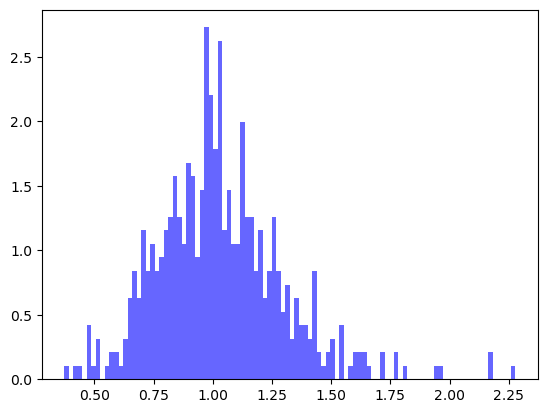

In [27]:
import scipy.io as sio
import json
import sys
sys.path.append(r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/Benchmark_example/")
import numpy as np
import Benchmark_Example as BM_E
import matplotlib.pyplot as plt
config_file_path = r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/config/config_BM_BlackScholes.json"
save_dir = r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/TrainResult"

Model = StochasticPCE(config_file_path, numDOE= None)

Y = BM_E.Benchmark_BlackScholes(Model.X)


reshaped_Y = np.reshape(Y, (len(Y), 1))
Model.InputRealization(reshaped_Y)



print(np.var(Y))
#Model.BuildModel_SPCE(tol_err=1E-8, show_info_ = False, overfit_count_ = 100,  save_result_ = True, result_path_ = save_dir)
Model.BuildModel_PCE(tol_err=1E-8, show_info_ = False, overfit_count_ = 100,  save_result_ = False, result_path_ = save_dir)
#Model.Read_result(save_dir,"SPCE_Result_0217101736.json")
#Model.SensitivityAnalysis(NumIndices= 6, Qol_based= False,show_info_=True)
#SPCE_Result_0217023956.json
#SPCE_Result_0217035719.json
#Y_real = np.array([])
#for i in range(1000):
#    Y_real_i = BM_E.Benchmark_BlackScholes(np.array([[0.07,0.13]]))
#    Y_real = np.append(Y_real, Y_real_i)
Y_real = reshaped_Y .reshape(-1,1)

a = np.zeros((10000,2))
a[:,0] = 0.4
a[:,1] = -0.8

#X_pred, Y_pred = Model.Predict_SPCE(load_type = "np_arr",Predict_type = "all_X", input_X = a)
#X_pred, Y_pred = Model.Predict_SPCE(load_type = "mat_file",Predict_type = "all_X", input_X = Model.X_path)



#print(Model.Sigma)

# Plot the histogram
plt.hist(Y_real.flatten(), bins=100, density=True, alpha=0.6, color='b')
#plt.hist(Y_pred.flatten(), bins=100, density=True, alpha=0.6, color='r')
plt.show()
# Add labels and title
#plt.xlabel('Value')
#plt.ylabel('Frequency')
#plt.title('Histogram of Gaussian Distribution')

# Show the plot

#plt.show()


# Plot simulated stock price
#print(Model.err_loo_min)
#plt.hist(Y, bins=30, color='blue', alpha=0.7) 
#plt.title('Simulated Stock Price')
#plt.xlabel('Time')
#plt.ylabel('Stock Price')
#plt.grid(True)
#plt.show()



-------------------------------------------------------------------------------
Initialized SPCE successfully
     Using Stochastic PCE solver
     Input X with shape (N,num_Vars): (500, 3)
     Input Y with shape (N,1)       : (0,)
     WARNING, No realization will be inputed when initialize the clase 
           Please use method: InputRealization() to initialize realization Y
 
     Config information: 
   {
    "X_path": "C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/InputData/Ishigami_DOE_500.mat",
    "X_type": {
        "x1": "Uniform",
        "x2": "Uniform",
        "x3": "Uniform"
    },
    "OrthPolyParams": {},
    "Z_type": [
        "Gaussian"
    ],
    "Solver": "HybridLAR",
    "max_poly_degree": 4,
    "q_norm": [
        0.7
    ],
    "save_result_path": "C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE"
}
-------------------------------------------------------------------------------
Input Realization
Input Realization successful

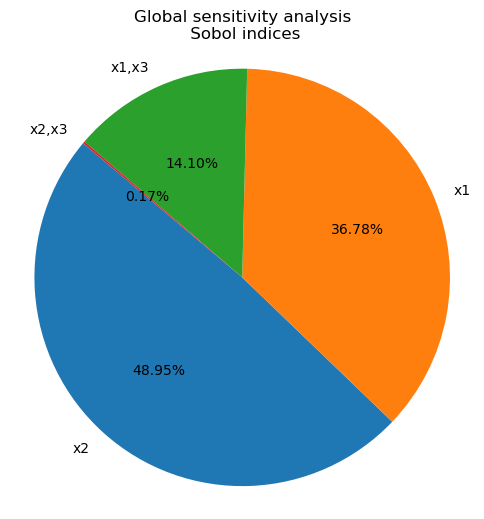

Perform Sensitivity Analysis succesfully


{'x2': 0.4895098396568637,
 'x1': 0.36776893041230874,
 'x1,x3': 0.14102403426894133,
 'x2,x3': 0.0016971956618863921}

In [12]:
import scipy.io as sio
import json
import sys
sys.path.append(r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/Benchmark_example/")
import numpy as np
import Benchmark_Example as BM_E
import matplotlib.pyplot as plt

config_file_path = r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/config/config_BM_Ishigami.json"
save_dir = r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/TrainResult"


Model = StochasticPCE(config_file_path, numDOE= None)
Y = BM_E.Benchmark_Ishigami_s(Model.X*np.pi)
reshaped_Y = np.reshape(Y, (len(Y), 1))
Model.InputRealization(reshaped_Y)

print(np.var(Y))
#Model.BuildModel_SPCE(tol_err=1E-4, show_info_ = False, overfit_count_ = 2,  save_result_ = True, result_path_ = save_dir)
Model.Read_result(save_dir,"SPCE_Result_0213083320.json")
Model.SensitivityAnalysis(NumIndices= 4, Qol_based= True,show_info_=True)
#print(Model.err_loo_min)
#a, b = Model.CreateOrderTable(3, 1)
#non_zero_rows = b[b[:, 3] != 0]
#print(b)
#print(non_zero_rows)

#Model.CreateInfoMatrix()


#### Borehole benchmark

-------------------------------------------------------------------------------
Initialized SPCE successfully
     Using conventional LAR-PCE solver
     Input X with shape (N,num_Vars): (300, 8)
     Input Y with shape (N,1)       : (0,)
     WARNING, No realization will be inputed when initialize the clase 
           Please use method: InputRealization() to initialize realization Y
 
     Config information: 
   {
    "X_path": "C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/InputData/Borehole_DOE_500.mat",
    "X_type": {
        "x1": "Gaussian",
        "x2": "Uniform",
        "x3": "Uniform",
        "x4": "Uniform",
        "x5": "Uniform",
        "x6": "Uniform",
        "x7": "Uniform",
        "x8": "Gaussian"
    },
    "OrthPolyParams": {},
    "Z_type": [],
    "Solver": "HybridLAR",
    "max_poly_degree": 5,
    "q_norm": [
        1
    ],
    "save_result_path": "C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE"
}
-------------------

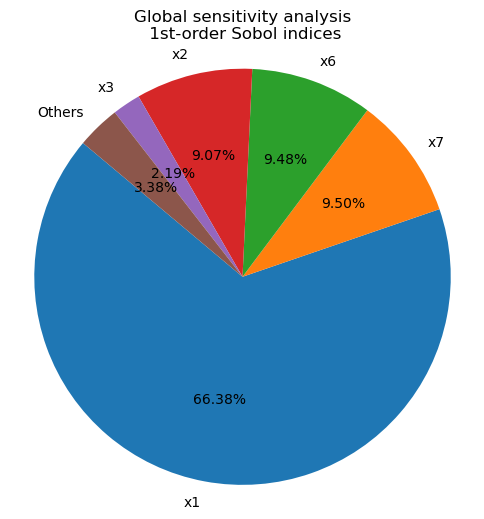

Perform Sensitivity Analysis succesfully


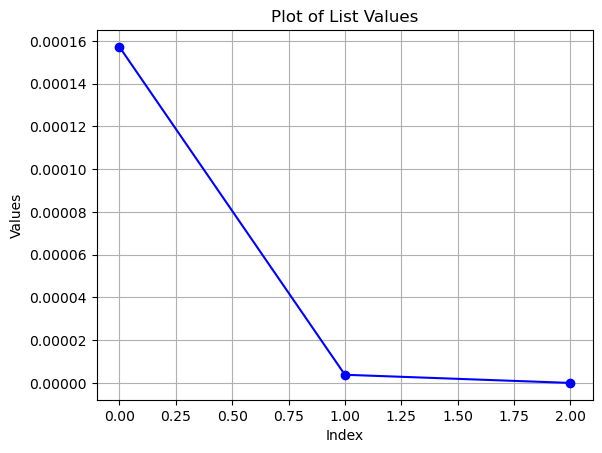

In [127]:
import scipy.io as sio
import json
import sys
sys.path.append(r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/Benchmark_example/")
import numpy as np
import Benchmark_Example as BM_E
import matplotlib.pyplot as plt

config_file_path = r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/config/config_BM_Bordhole.json"
save_dir = r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/TrainResult"
Model = StochasticPCE(config_file_path, numDOE= 300)

# Realization
Y = BM_E.Benchmark_borehole(Model.X)
reshaped_Y = np.reshape(Y, (len(Y), 1))
Model.InputRealization(reshaped_Y)

Model.BuildModel_PCE(tol_err=1E-6, show_info_ = False, overfit_count_ = 2,  save_result_ = False, result_path_ = save_dir)
Model.SensitivityAnalysis(NumIndices= 5, show_info_=True)

# Plot the list of values
plt.plot(Model.error_corr_record, marker='o', color='b', linestyle='-')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of List Values')

# Show the plot
plt.grid(True)
plt.show()


#### Ishigami model benchmark

-------------------------------------------------------------------------------
Initialized SPCE successfully
     Using conventional LAR-PCE solver
     Input X with shape (N,num_Vars): (500, 3)
     Input Y with shape (N,1)       : (0,)
     WARNING, No realization will be inputed when initialize the clase 
           Please use method: InputRealization() to initialize realization Y
 
     Config information: 
   {
    "X_path": "C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/InputData/Ishigami_DOE_500.mat",
    "X_type": {
        "x1": "Uniform",
        "x2": "Uniform",
        "x3": "Uniform"
    },
    "OrthPolyParams": {},
    "Z_type": [],
    "Solver": "HybridLAR",
    "max_poly_degree": 14,
    "q_norm": [
        0.5,
        0.75,
        1.0
    ],
    "save_result_path": "C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE"
}
-------------------------------------------------------------------------------
Input Realization
Input Realization 

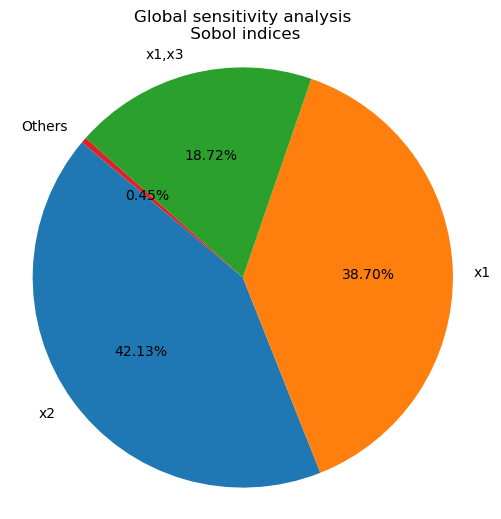

Perform Sensitivity Analysis succesfully
-------------------------------------------------------------------------------
Start Prediction, variables X will be overwritten.
-------------------------------------------------------------------------------
Create Information Matrix
Create Information Matrix successfully, shape: (500, 9)
Generate predicted data, X_pred: ((500, 3), Y_pred: ((500, 1)).


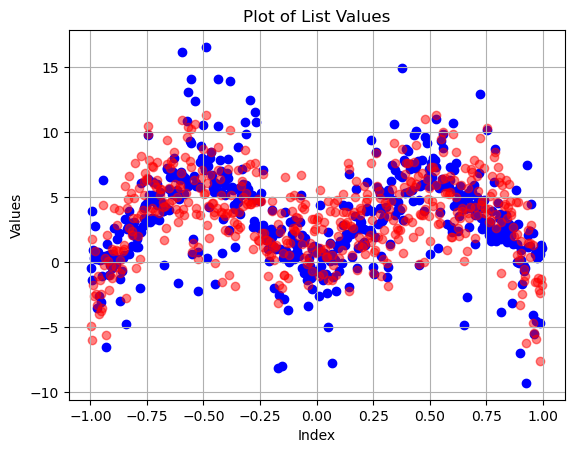

In [45]:
import scipy.io as sio
import json
import sys
sys.path.append(r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/Benchmark_example/")
import numpy as np
import Benchmark_Example as BM_E
import matplotlib.pyplot as plt

config_file_path = r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/config/config_BM_Ishigami.json"
save_dir = r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/TrainResult"


Model = StochasticPCE(config_file_path, numDOE= None)

Y = BM_E.Benchmark_Ishigami(Model.X*np.pi)
reshaped_Y = np.reshape(Y, (len(Y), 1))
Model.InputRealization(reshaped_Y)

X_train, Y_train = Model.BuildModel_PCE(tol_err=1E-10, show_info_ = False, overfit_count_ = 2,  save_result_ = True, result_path_ = save_dir)
#Model.Read_result(save_dir,"PCE_Result_0217065852.json")
Model.SensitivityAnalysis(NumIndices= 3, show_info_=True)
X_pred, Y_pred = Model.Predict_PCE(load_type = 'mat_file', input_X = Model.X_path)


# Plot the list of values
#plt.plot(Model.error_corr_record, marker='o', color='b', linestyle='-')
plt.scatter(Model.X[:,1], Y, marker='o', color='b')
plt.scatter(X_pred[:,1], Y_pred, marker='o', alpha=0.5,color='r')


# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of List Values')

# Show the plot
plt.grid(True)
plt.show()

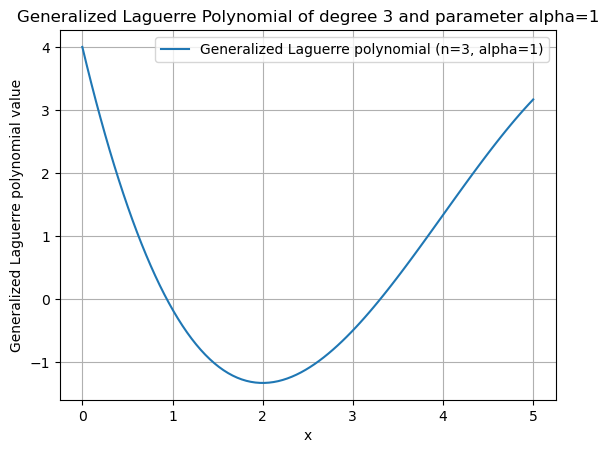

In [68]:
from scipy.special import eval_genlaguerre
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
n = 3       # Degree of the generalized Laguerre polynomial
alpha = 1   # Parameter alpha
x_values = np.linspace(0, 5, 100)  # Generate 100 points from 0 to 5

# Evaluate the generalized Laguerre polynomial at x_values
L_values = eval_genlaguerre(n, alpha, x_values)

# Plot the generalized Laguerre polynomial values
plt.plot(x_values, L_values, label=f"Generalized Laguerre polynomial (n={n}, alpha={alpha})")

# Add labels and title
plt.xlabel('x')
plt.ylabel('Generalized Laguerre polynomial value')
plt.title(f'Generalized Laguerre Polynomial of degree {n} and parameter alpha={alpha}')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()





In [18]:
from scipy.optimize import minimize

# Define the objective function
def objective_function(x):
    return (x[0] - 1)**2 + (x[1] - 2.5)**2

# Initial guess
initial_guess = [0, 0]
print(type(initial_guess))

# Optimize using BFGS
result = minimize(objective_function, initial_guess, method='BFGS')

# Print the result
print("Optimization result:")
print("Optimal parameters:", result.x)
print("Optimal function value:", result.fun)

gq_int_all = np.polynomial.legendre.leggauss(4)
print(gq_int_all)


<class 'list'>
Optimization result:
Optimal parameters: [0.99999996 2.50000001]
Optimal function value: 1.968344227868139e-15
(array([-0.86113631, -0.33998104,  0.33998104,  0.86113631]), array([0.34785485, 0.65214515, 0.65214515, 0.34785485]))


In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, train_test_split
from skopt import gp_minimize
from skopt.space import Real
from sklearn.svm import SVC

# Generate a synthetic classification dataset
X, y = make_classification(
    n_samples=1000,  # Number of samples
    n_features=20,   # Number of features
    n_classes=2,     # Number of classes
    random_state=42  # Random seed for reproducibility
)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function with N-fold cross-validation
def objective_function(params):
    # Extract hyperparameters
    C, gamma = params
    
    # Define the classifier with the given hyperparameters
    clf = SVC(C=C, gamma=gamma)
    
    # Compute the cross-validation score (e.g., accuracy)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    
    # Return the negative mean score (to be maximized by Gaussian process optimization)
    return -scores.mean()

# Define the search space for hyperparameters
space = [Real(1e-6, 1e+6, "log-uniform", name='C'),
         Real(1e-6, 1e+1, "log-uniform", name='gamma')]

# Perform Gaussian process optimization
result = gp_minimize(objective_function, space, n_calls=10, random_state=42)

# Get the optimal hyperparameters
optimal_params = result.x

# Train the model using the optimal hyperparameters
clf = SVC(C=optimal_params[0], gamma=optimal_params[1])
clf.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = clf.score(X_test, y_test)
print("Test set accuracy:", accuracy)



Test set accuracy: 0.88


In [ ]:
import json
import sys
sys.path.append(r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/Benchmark_example/")
import numpy as np
import maxTF_SDOF as TF


# Specify the path to your JSON config file
config_file_path = r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/config/config.json"

save_dir = r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/TrainResult"

m_t = 100
sigma_m = 10

c_t = 100
sigma_c = 5

lb_k = 4*(np.pi**2)*8000
ub_k = 4*(np.pi**2)*12000
k_t = (lb_k + ub_k) / 2
sigma_k = (ub_k - lb_k) / np.sqrt(12)

mean = np.array([m_t,c_t,k_t])
std  = np.array([sigma_m,sigma_c,sigma_k])


Model = StochasticPCE(config_file_path)

Y = TF.realization_SDOF(Model.X_path, mean, std,)
reshaped_Y = np.reshape(Y, (len(Y), 1))

Model.InputRealization(reshaped_Y)


#A = Model.CreateOrderTable(3,1)
#poly_degreeA = A[:,0]
#poly_degreeA = poly_degreeA.reshape(-1, 1)
#poly_degreeB = A[:,1]
#poly_degreeB = poly_degreeB.reshape(-1, 1)
#poly_degreeC = A[:,2]
#poly_degreeC = poly_degreeC.reshape(-1, 1)
#Model.X[:,0] = Model.X[:,0].reshape(1,-1)

#print(poly_degree)
#print(Model.X[:,0])


#A = Model.Hilbertian_basis_Hermite(poly_degreeA,Model.X[:,0])
#B = Model.Hilbertian_basis_Hermite(poly_degreeB,Model.X[:,1])
#C = Model.Hilbertian_basis_Legendre(poly_degreeC,Model.X[:,2])

#X = Model.CreateInfoMatrix(True,True)
#print(np.shape(X))
#a,b,c,d = Model.Solver(solver_= "HybridLAR", show_info_= True)
#print(a,b,c,d)
#Model.LOOCV()




X_train, Y_train = Model.BuildModel(tol_err=1E-10, show_info_ = True, overfit_count_ = 100, save_result_ = False, result_path_ = save_dir)
# Plot the list of values
plt.plot(Model.error_corr_record, marker='o', color='b', linestyle='-')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of List Values')

# Show the plot
plt.grid(True)
plt.show()
#Model.SensitivityAnalysis(show_info_=True)

#print(Model.p, Model.q)
#Model.Save_result(Model.result_path)
#Model.Read_result(save_dir, "Result_0129202504.json")
#X_pred,Y_pred = Model.Predict(load_type="mat_file", input_X=r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/InputData/samples_500.mat" )
#X = np.array([0.01, 0.01, 0.01])
#X = X.reshape(1,-1)

#X_train,Y_train = Model.Predict(load_type="np_arr", input_X=X)
#print(Model.p, Model.q)

#print(np.shape(X_train),np.shape(Y_train))
#print(np.shape(X_pred),np.shape(Y_pred))

#print(Model.overfit)
#print(Model.converge)
#plt.scatter(Model.X_train[:,1], Model.Y, label='Train')
#plt.scatter(X_train[:,1], Y_train, label='Predict')
#
## Add title and labels
#=plt.title('Simple Line Plot')
#plt.xlabel('X-axis')
#plt.ylabel('Y-axis')
# Add a legend
#plt.legend()
# Show the plot
#plt.show()

#print(Model.hybridLAR_solver())
#print(Model.LAR_solver())
#print(Model.LeastSquare_solver().T)

#check normalized
#print(np.mean(A*A,axis=0))
#print(np.mean(B*B,axis=0))
#print(np.mean(C*C,axis=0))
#print(np.mean(A*C,axis=0))
#print(np.mean(B*C,axis=0))



#y_alpha = np.linalg.inv(X.T @ X) @ X.T @ Model.Y
#print(y_alpha)
#
#
#
## Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, Model.Y, test_size=0.2, random_state=42)
#
## Create a Lars model
#lars_model = Lars()
#
## Fit the model to the training data
#lars_model.fit(X_train, y_train)
#
#print(lars_model.coef_)
#print(lars_model.active_)
##reg.coef_[reg.coef_ > 3] = 0
## Make predictions on the test set
#predictions = lars_model.predict(X_test)
#
## Evaluate the model
#mse = mean_squared_error(y_test, predictions)
##print(f"Mean Squared Error: {mse}")



